# מודל לחיזוי לקוחות הפוטנציאליים שיש להם סבירות גבוהה יותר לרכוש ביטוח לרכב

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
# Read-in train and test datasets
train = pd.read_csv('datasets_1411_2534_carInsurance_train.csv')
test = pd.read_csv('datasets_1411_2534_carInsurance_test.csv')

In [7]:
print('The train dataset has %d observations and %d features' % (train.shape[0], train.shape[1]))
print('The test dataset has %d observations and %d features' % (test.shape[0], test.shape[1]))

The train dataset has 4000 observations and 19 features
The test dataset has 1000 observations and 19 features


## במערך הנתונים
הנתונים כוללים מידע דמוגרפי של לקוחות (גיל, הכנסה וכו ')

In [8]:
# Take a peak at the data
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [9]:
train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,10:42:44,11:27:46
freq,893,2304,1988,2831,1049,437,3,3


In [10]:
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


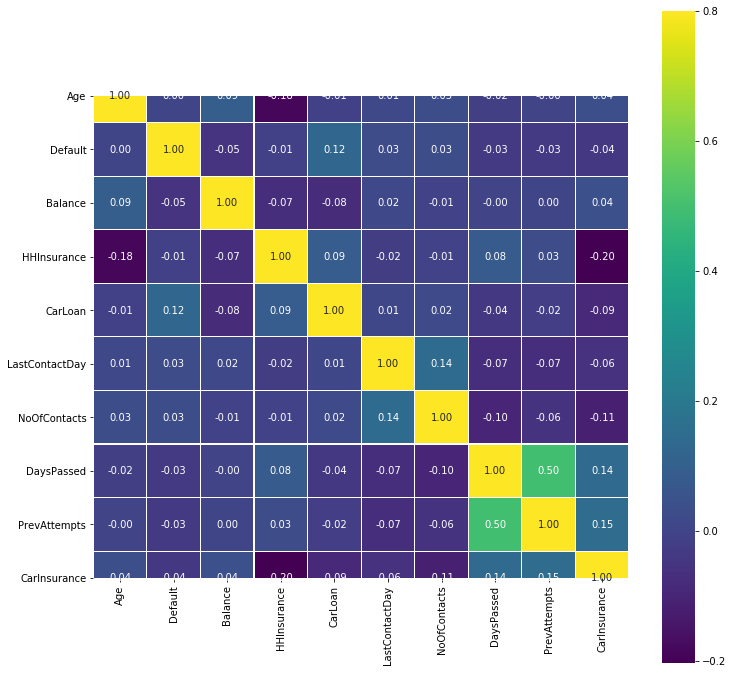

In [11]:
# First check out correlations among numeric features
# Heatmap is a useful tool to get a quick understanding of which variables are important
colormap = plt.cm.viridis
cor = train.corr()
cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


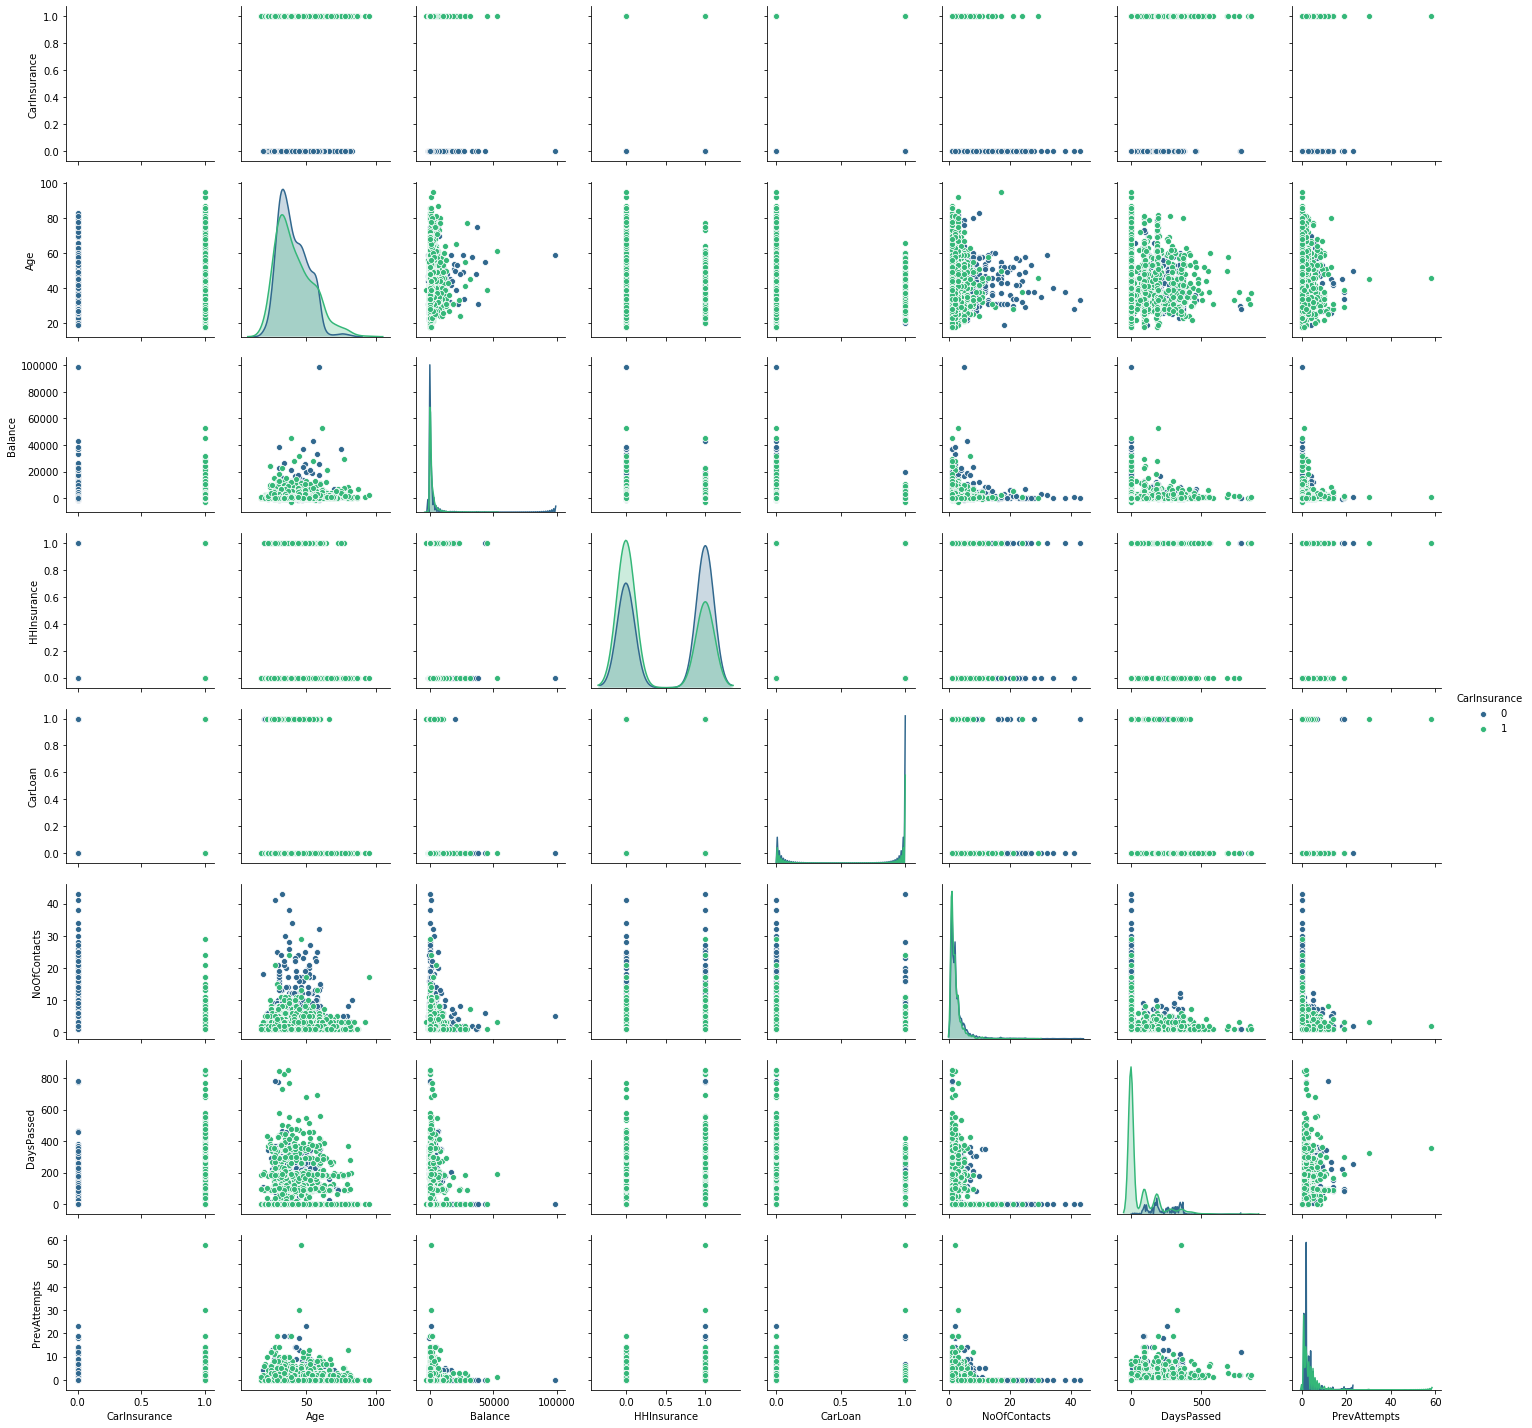

In [12]:
# Next, pair plot some important features
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats],hue='CarInsurance',palette='viridis',size=2.5)
plt.show()

## השפעת הגיל על רכישת ביטוח לרכב 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:838: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  func(*plot_args, **plot_kwargs)


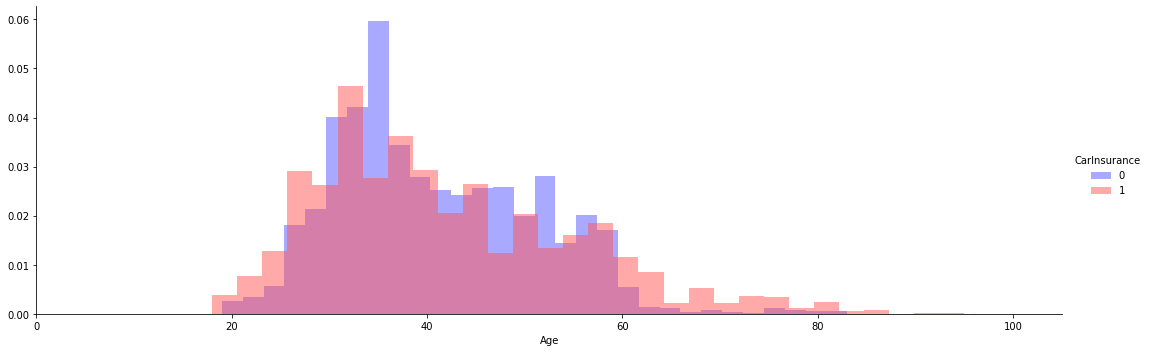

In [13]:
facet = sns.FacetGrid(train, hue='CarInsurance',size=5,aspect=3,palette='seismic')
facet.map(plt.hist,'Age',bins=30,alpha=0.5,normed=True)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

### נראה שצעירים (<= 30 שנה) וקשישים נוטים יותר לקנות ביטוח רכב

## נבדוק את השפעת המשתנים הקטגורים על משתנה מטרה

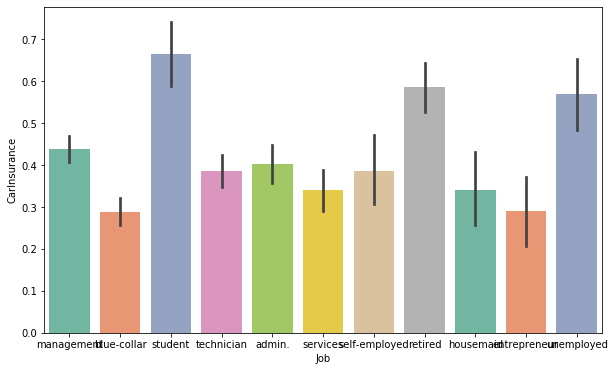

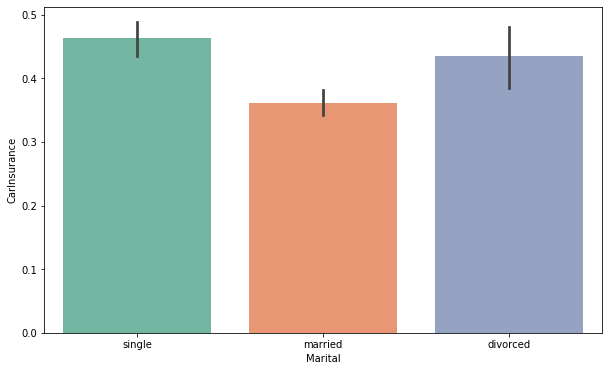

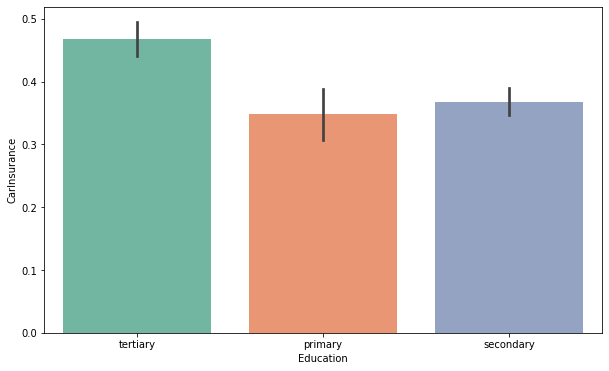

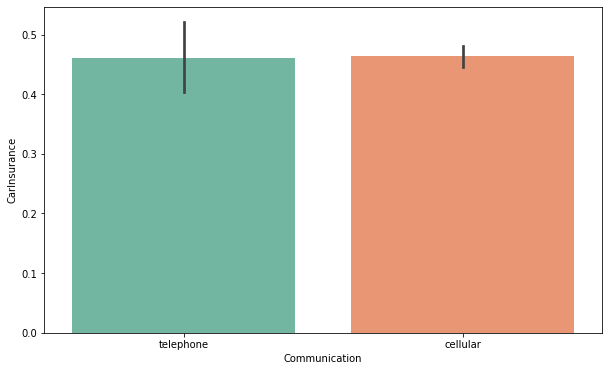

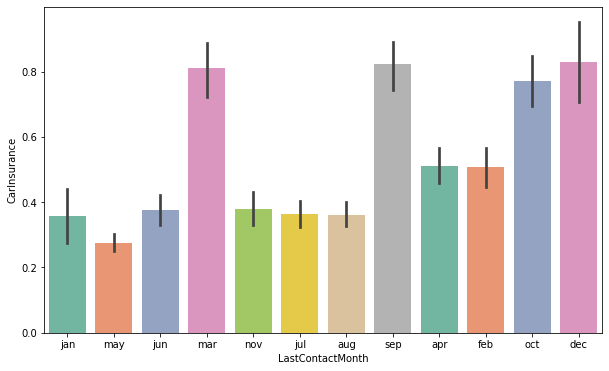

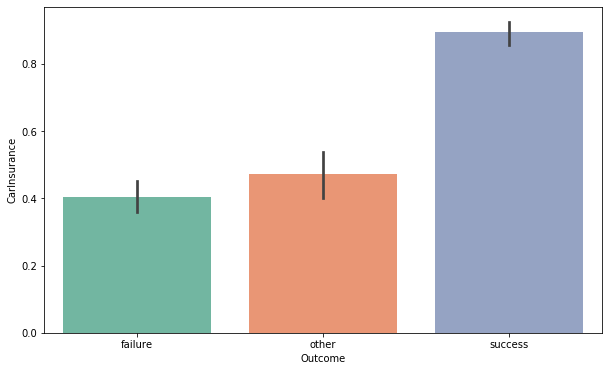

In [14]:
# Next check out categorical features
cat_feats = train.select_dtypes(include=['object']).columns
plt_feats = cat_feats[(cat_feats!= 'CallStart') & (cat_feats!='CallEnd')]

for feature in plt_feats:
    plt.figure(figsize=(10,6))
    sns.barplot(feature,'CarInsurance', data=train,palette='Set2') 

<br> <b>מקצוע</b>: הסטודנטים נוטים לרכוש ביטוח, ואחריהם אנשים גמלאים ומובטלים
<br> <b>מצב משפחתי</b>: אנשים נשואים נוטים פחות לקנות ביטוח רכב. הזדמנויות לפיתוח עסק לביטוח משפחה
<br> <b>השכלה</b>: אנשים עם השכלה גבוהה נוטים יותר לרכוש

In [16]:
# Check outliers
# From the pairplot, we can see there is an outlier with extreme high balance. Drop that obs here.
train[train['Balance']>80000]
train = train.drop(train[train.index==1742].index)

In [12]:
# merge train and test data here in order to impute missing values all at once
all=pd.concat([train,test],keys=('train','test'))
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4999, 17)


In [13]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3798,0.759752
Communication,1123,0.224645
Education,216,0.043209
Job,24,0.004801


## מודלים

In [22]:
# Create a cross validation function 
def get_best_model(estimator, params_grid={}):
    
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [23]:
# Create a model fitting function
def model_fit(model,feature_imp=True,cv=5):

    # model fit   
    clf = model.fit(x_train,y_train)
    
    # model prediction     
    y_pred = clf.predict(x_test)
    
    # model report     
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        feat_imp = pd.Series(clf.feature_importances_,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")


In [24]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']


### k-Nearest Neighbors (KNN)


--- Best Parameters -----------------------------
{'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

--- Best Model -----------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')

--- Train Set -----------------------------
Accuracy: 0.81854 +/- 0.0222
AUC: 0.88925 +/- 0.0154

--- Validation Set -----------------------------
Accuracy: 0.76491 +/- 0.0254
AUC: 0.84183 +/- 0.0121
-----------------------------------------------


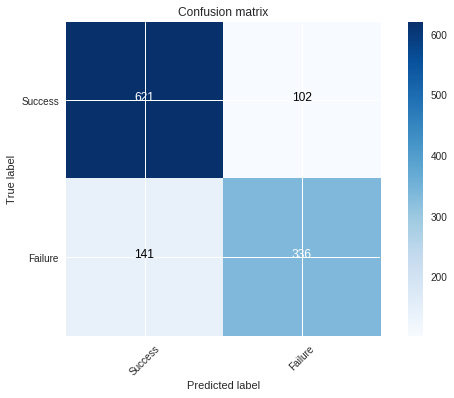

In [25]:
# Let's start with KNN. An accuracy of 0.76 is not very impressive. I will just take this as the model benchmark. 
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7], 
              'p':[1,2],
              'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)
model_fit(model=clf_knn, feature_imp=False)

### Naive Bayes Classifier


--- Train Set -----------------------------
Accuracy: 0.75849 +/- 0.0148
AUC: 0.81460 +/- 0.0092

--- Validation Set -----------------------------
Accuracy: 0.73331 +/- 0.0122
AUC: 0.79530 +/- 0.0341
-----------------------------------------------


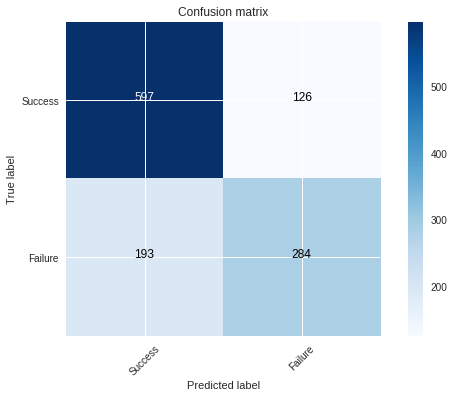

In [26]:
# As expected, Naive Bayes classifier doesn't perform well here. 
# There are multiple reasons. Some of the numeric features are not normally distributed, which is a strong assemption hold by Naive Bayes. 
# Also, features are definitely not independent.  
clf_nb = GaussianNB()
model_fit(model=clf_nb,feature_imp=False)

### Logistic Regression


--- Best Parameters -----------------------------
{'C': 0.9, 'penalty': 'l1'}

--- Best Model -----------------------------
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.81923 +/- 0.0112
AUC: 0.89938 +/- 0.0132

--- Validation Set -----------------------------
Accuracy: 0.80413 +/- 0.0109
AUC: 0.88579 +/- 0.0133
-----------------------------------------------


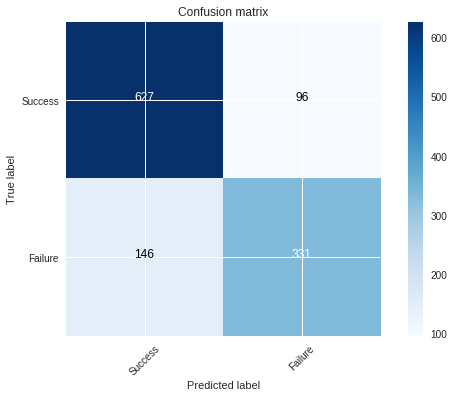

In [27]:
# We're making progress here. Logistic regression performs better than KNN. 
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)

### Random Forest


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 13, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.84495 +/- 0.0074
AUC: 0.92308 +/- 0.0078

--- Validation Set -----------------------------
Accuracy: 0.82081 +/- 0.0115
AUC: 0.90453 +/- 0.0081
-----------------------------------------------


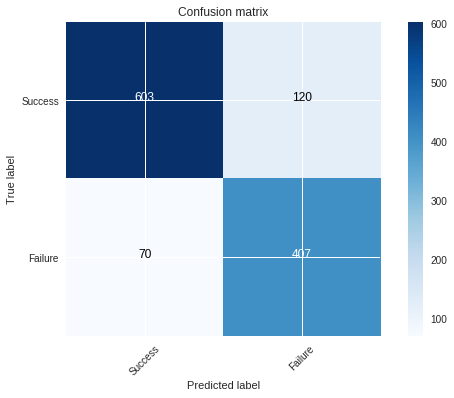

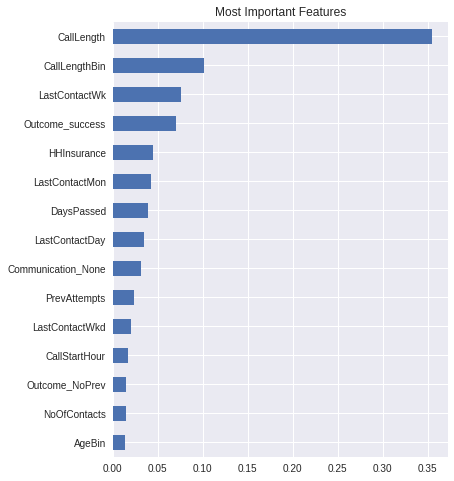

In [28]:
# I did some manual parameter tuning here. This is the best model so far. 
# Based on the feature importance report, call length, last contact week, and previous success are strong predictors of cold call success
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)

### Support Vector Machines


--- Best Parameters -----------------------------
{'C': 1, 'gamma': 0.01}

--- Best Model -----------------------------
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

--- Train Set -----------------------------
Accuracy: 0.83569 +/- 0.0215
AUC: 0.90523 +/- 0.0149

--- Validation Set -----------------------------
Accuracy: 0.78242 +/- 0.0253
AUC: 0.86055 +/- 0.0155
-----------------------------------------------


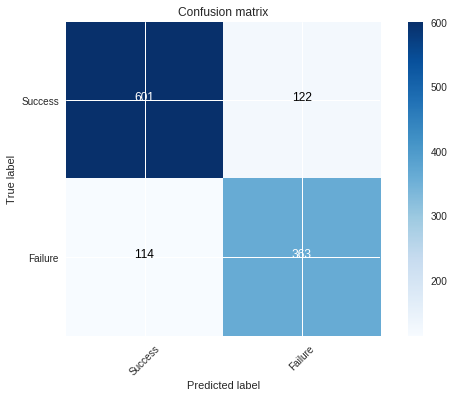

In [29]:
# try a SVM RBF model 
svc = svm.SVC(kernel='rbf', probability=True, random_state=3)
parameters = {'gamma': [0.005,0.01,0.02],
              'C': [0.5,1,5]}
clf_svc = get_best_model(svc, parameters)
model_fit(model=clf_svc,feature_imp=False)

### XGBoost


--- Best Parameters -----------------------------
{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

--- Train Set -----------------------------
Accuracy: 0.85424 +/- 0.0052
AUC: 0.93485 +/- 0.0070

--- Validation Set -----------------------------
Accuracy: 0.82995 +/- 0.0263
AUC: 0.91539 +/- 0.0144
-----------------------------------------------


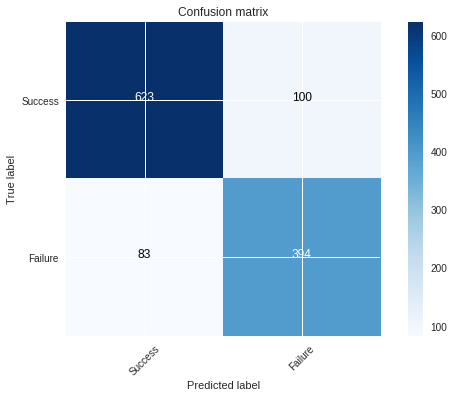

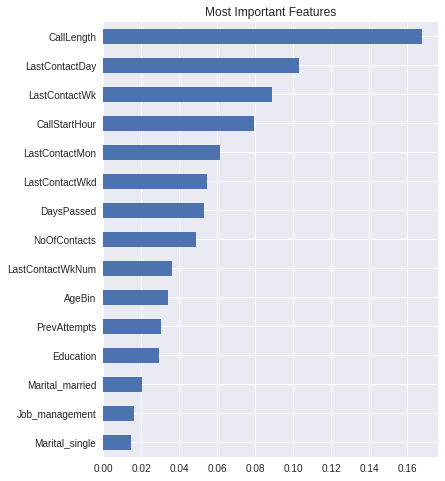

In [30]:
# Finally let's try out XBGoost. As expected, it outperforms all other algorithms. 
# Also, based on feature importances, some of the newly created features such as call start hour, last contact week and weekday 
# have been picked as top features. 

import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb= get_best_model(xgb,parameters)
model_fit(model=clf_xgb, feature_imp=True)

## הערכת המודלים

In [31]:
# Compare model performance
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_svc, clf_xgb]
index =['K-Nearest Neighbors','Naive Bayes','Logistic Regression','Random Forest','Support Vector Machines','XGBoost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

XGBoost                    0.829952
Random Forest              0.820813
Logistic Regression        0.804129
Support Vector Machines    0.782417
K-Nearest Neighbors        0.764906
Naive Bayes                0.733312
dtype: float64